<a href="https://colab.research.google.com/github/ejrtks1020/Kaggle_Computer_Vision/blob/main/Kaggle_Steel_Defect_Detection_Inference_(Mask_R_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
*-!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.3 MB/s 


In [ ]:
# https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.  
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [ ]:
# 런타임->런타임 다시 시작 후 아래 수행. 
from mmdet.apis import init_detector, inference_detector
import mmcv

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/severstal-steel-defect-detection.zip"

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')

In [ ]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


# 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 2022)

In [ ]:
train_df['train'] = True
val_df['train'] = False
train_val = pd.concat([train_df, val_df])

# Annotation정보를 coco json format으로 변환

In [ ]:
import os.path as osp
import json
from tqdm.notebook import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder

# coco json 형태로 변환
def convert_to_coco(ann_df, out_file, image_prefix):
  ''' ann_file은 via_region_data.json, out_file은 coco로 변환할 출력 json파일
      image_prefix는 image jpg가 있는 디렉토리 위치 
  '''

  # coco의 주요 key값인 annotations와 images를 담을 list 생성. 
  annotations = []
  images = []
  obj_count = 0

  le = LabelEncoder()
  image_id_encoded = le.fit_transform(ann_df.ImageId)
  ann_df['image_id_encoded'] = image_id_encoded

  img_id_list = ann_df['ImageId'].drop_duplicates().values
  for image_id in img_id_list:
    img_path = os.path.join(image_prefix, image_id)
    height, width = cv2.imread(img_path).shape[:2]
    img_id = int(le.transform([image_id])[0])
    
    images. append(dict(
        id = img_id,
        file_name = image_id,
        height = height,
        width = width
    ))

  for idx, (image_id, class_id, pixels, train, image_id_encoded) in ann_df.iterrows():

    pixels = pixels.split()
    pixels = np.array(pixels, dtype = int)
    pixels = pixels.reshape(-1, 2)

    img_path = os.path.join(image_prefix, image_id)
    height, width = cv2.imread(img_path).shape[:2]
    mask = np.zeros(height * width)

    for start, length in pixels:
      mask[start : start + length] = 255
    
    mask = mask.reshape((height, width), order = 'F')
    mask = np.array(mask, dtype = np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
      
      if len(contours[i]) > 2:
        poly = np.squeeze(contours[i])
        x_min, y_min, x_max, y_max = int(min(poly[:, 0])), int(min(poly[:, 1])), int(max(poly[:, 0])), int(max(poly[:, 1]))
        poly = list(poly.flatten())
        poly = [int(x) for x in poly]
        data_anno = dict(
              image_id = image_id_encoded,
              id=obj_count,
              category_id = class_id,
              bbox = [x_min, y_min, x_max - x_min, y_max - y_min],
              area = (x_max - x_min) * (y_max - y_min),
              segmentation = [poly],
              iscrowd = 0
          )
        annotations.append(data_anno)
        obj_count += 1

  # images와 annotations, categories를 Dict형태로 저장. 
  coco_format_json = dict(
      images = images,
      annotations = annotations,
      categories = [{'id':1, 'name':'1'},
                    {'id':2, 'name':'2'},
                    {'id':3, 'name':'3'},
                    {'id':4, 'name':'4'}]
  )
  
  # json 파일로 출력. 
  #mmcv.dump(coco_format_json, out_file)
  with open(out_file, 'w') as json_out_file:
    json.dump(coco_format_json, json_out_file)

In [ ]:
convert_to_coco(val_df, '/content/val.json', '/content/val_images')

# Config 설정

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force = True)
class SteelDataset(CocoDataset):
  CLASSES = ('1', '2', '3', '4')

In [ ]:
from mmcv import Config
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [ ]:
!mkdir val_images

In [ ]:
# validation용 이미지를 따로 저장
import shutil
val_imgs = val_df.ImageId.drop_duplicates().values
for fname in val_imgs:
  src = os.path.join('/content/train_images', fname)
  dst = os.path.join('/content/val_images', fname)
  shutil.copyfile(src, dst)

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정
cfg.dataset_type = 'SteelDataset'
cfg.data_root = '/content/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'SteelDataset'
cfg.data.train.data_root = '/content/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'train_images'

cfg.data.val.type = 'SteelDataset'
cfg.data.val.data_root = '/content/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'val_images'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4
cfg.model.roi_head.mask_head.num_classes = 4

# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = '/content/drive/MyDrive/Steel_detect_save'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# epochs 횟수는 36으로 증가 
cfg.runner.max_epochs = 36

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [ ]:
print(cfg.pretty_text)

### 단일 이미지 Inference 수행

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

checkpoint_file = '/content/drive/MyDrive/Steel_detect_save/epoch_36.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/drive/MyDrive/Steel_detect_save/epoch_36.pth


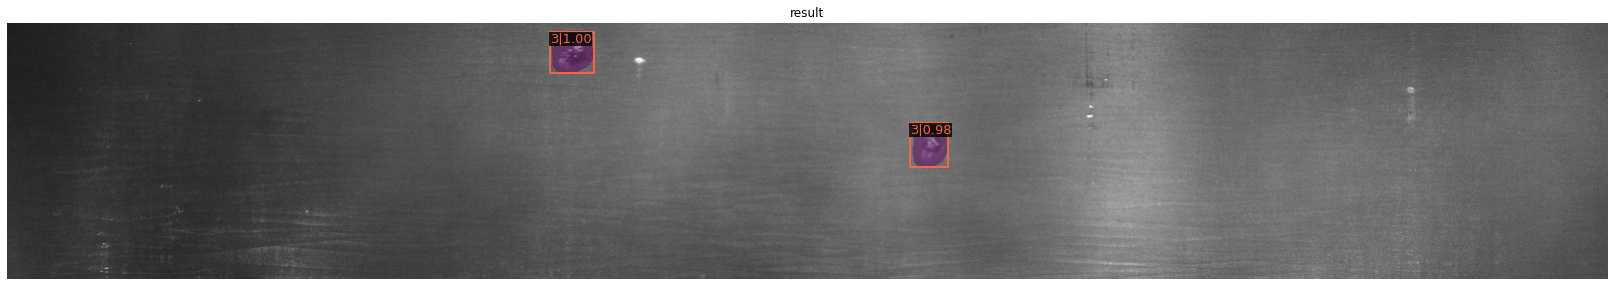

In [ ]:
# BGR Image 사용 
img = cv2.imread('/content/val_images/0139dd004.jpg')
result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

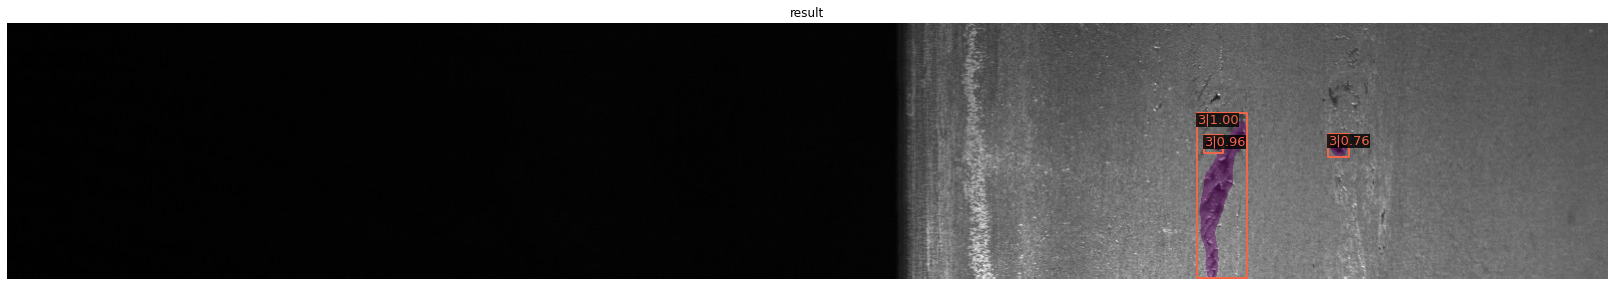

In [ ]:
img = cv2.imread('/content/val_images/03461f8e0.jpg')
result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

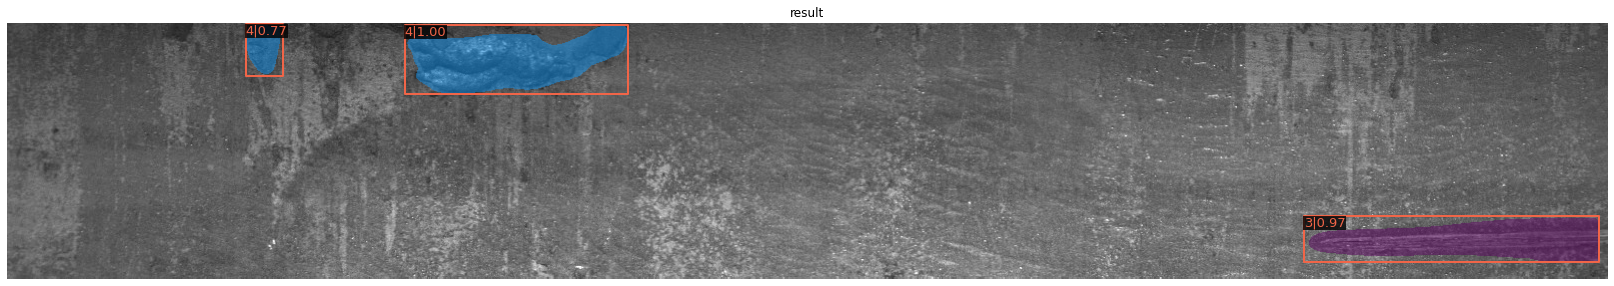

In [ ]:
img = cv2.imread('/content/val_images/0e232ce72.jpg')
result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

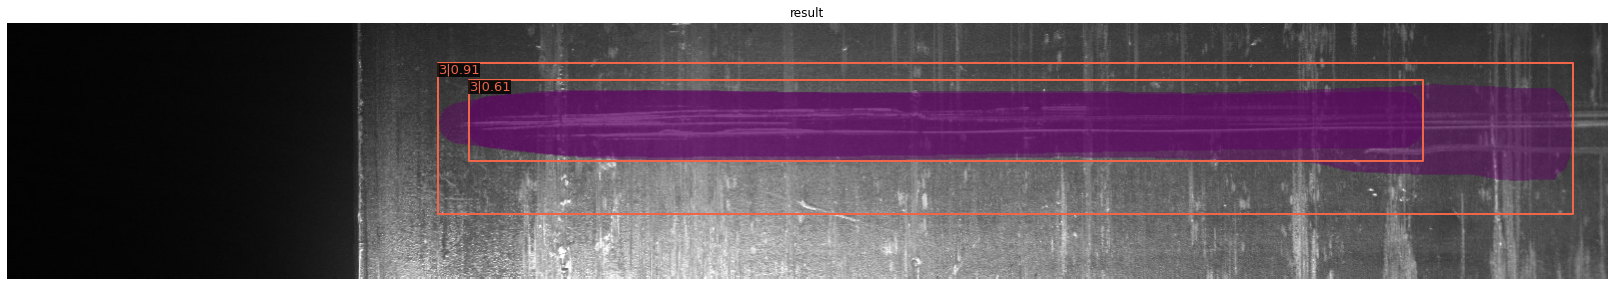

In [ ]:
img = cv2.imread('/content/val_images/031627893.jpg')
result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

In [ ]:
labels_to_names_seq = {0:'1',
                       1:'2',
                       2:'3',
                       3:'4'}

colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]])

In [ ]:
result[0]

[array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[4.3028931e+02, 4.0051319e+01, 1.5656665e+03, 1.9162134e+02,
         9.1270304e-01],
        [4.6154187e+02, 5.7683479e+01, 1.4150203e+03, 1.3835419e+02,
         6.0861212e-01],
        [1.3551737e+03, 3.3482707e+00, 1.4497600e+03, 2.5194234e+02,
         1.8201542e-01],
        [1.4088564e+03, 2.6113923e+00, 1.5881302e+03, 2.5133676e+02,
         1.6087034e-01],
        [1.1129591e+03, 3.5372654e-01, 1.5698975e+03, 2.5172762e+02,
         1.4798550e-01],
        [1.2497557e+03, 7.8469868e+00, 1.3338427e+03, 2.5222656e+02,
         7.5109519e-02],
        [1.3062998e+03, 4.5037961e+00, 1.4961450e+03, 2.5048875e+02,
         5.8372624e-02],
        [1.4749655e+03, 3.3203125e-02, 1.5243483e+03, 2.3581114e+02,
         5.4604657e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32)]

In [ ]:
# 컬러기반 Instance Segmentation을 적용하는 함수
def get_detected_img_n_gray(model, img_array, score_threshold = 0.3, draw_box = True, is_print = True):
  # 인자로 들어온 image_array를 복사.
  draw_img = img_array.copy()
  bbox_color = (0, 255, 0)
  text_color = (0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.
  # results는 4개(클래스 종류 갯수)의 2차원 array(shape = (오브젝트 갯수, 5))
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # 4개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id, 즉 result_ind가 class_id가 된다
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 클래스로 detect된 오브젝트가 없으므로 다음 loop(클래스)로 진행
    if len(bbox_result) == 0:
      continue
    
    mask_array_list = seg_results[result_ind]

    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨있음, 이 2차원 array를 row수만금 iteration해서 개별 오브젝트의 좌표값 추출.
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출.
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])

        # draw_box가 True라면 바운딩 박스 시각화
        if draw_box :
          cv2.rectangle(draw_img, (left, top), (right, bottom), color = bbox_color, thickness = 2)
          cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        
        # masking 시각화 적용. class_mask_array는 원본 이미지의 shape에서 True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출
        mask_roi = draw_img[class_mask_array]
        # color를 class별로 지정
        # color 종류가 클래스 종류보다 많으면 각각 다른 컬러 지정 가능
        color_index = result_ind % len(colors)
        color = colors[color_index]

        draw_img[class_mask_array] = ([0.3 * color[0], 0.3 * color[1], 0.3 * color[2]] + 0.6 * mask_roi).astype(np.uint8)

        if is_print:
          print(caption)

  return draw_img

3: 0.8971
3: 0.7999
3: 0.7865
3: 0.7356
3: 0.6901
3: 0.6137
3: 0.4870
3: 0.4205
3: 0.3837


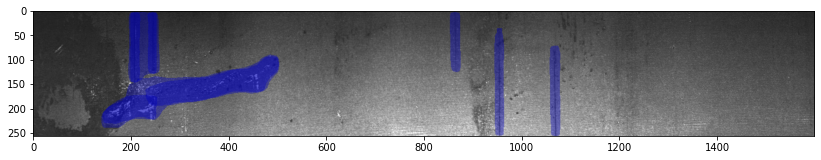

In [ ]:
img_arr = cv2.imread('/content/val_images/0bbd121d7.jpg')
detected_img = get_detected_img_n_gray(model_ckpt, img_arr, score_threshold = 0.3, draw_box = False, is_print = True)
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (14, 14))
plt.imshow(detected_img);

In [ ]:
def inference(model, img_path, score_threshold, draw_box = True, is_print = True):
  img_arr = cv2.imread(img_path)
  detected_img = get_detected_img_n_gray(model, img_arr, score_threshold = score_threshold, draw_box = draw_box, is_print = is_print)
  detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

  plt.figure(figsize = (14, 14))
  plt.imshow(detected_img);

2: 0.8342


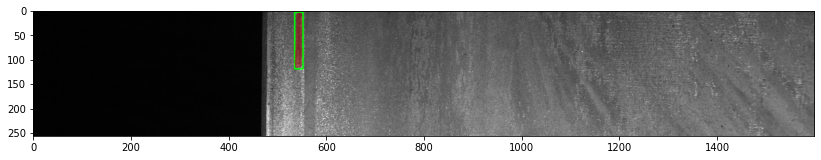

In [ ]:
inference(model_ckpt, '/content/val_images/0b5018316.jpg', score_threshold = 0.5)

3: 0.9757
3: 0.7611
3: 0.5542


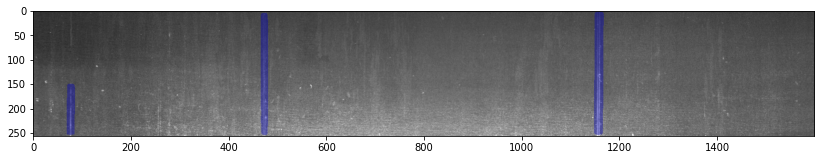

In [ ]:
inference(model_ckpt, '/content/val_images/0007a71bf.jpg', score_threshold = 0.5, draw_box = False)

In [ ]:
# 데이터프레임으로부터 encodedpixel값을 읽어 마스크를 반환하는 함수
def get_mask_from_df(df, image_id):
  indexes = df['ImageId'] == image_id
  path = '/content/val_images/'
  image = plt.imread(path + image_id)
  h, w = image.shape[:2]
  mask = np.zeros(h * w)
  for idx, (image_id, class_id, pixels, train, image_id_encoded) in df[indexes].iterrows():
    pixels = pixels.split()
    pixels = np.array(pixels, dtype = int)
    pixels = pixels.reshape(-1, 2)

    for start, length in pixels:
      mask[start : start + length] = 1
    
    mask = mask.reshape((h, w), order = 'F')
    mask_bool = mask.astype(bool)

  return image, mask

In [ ]:
# 이미지의 마스크 영역에 컬러를 적용하는 함수
def apply_mask(img, mask, color, alpha=0.5):
  image = img.copy()
  for c in range(3):
    image[:, :, c] = np.where(mask == 1,
                              image[:, :, c] *
                              (1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
  return image

# Inference 및 시각화

In [ ]:
val_imgs = os.listdir('/content/val_images')[:4]

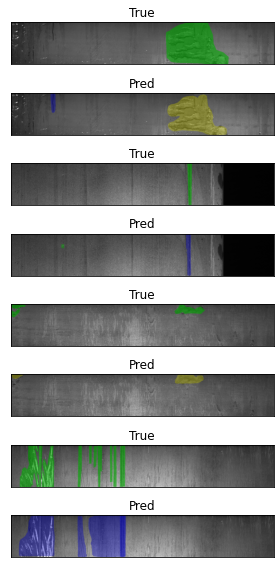

In [ ]:
nrows = 8
ncols = 1
fig, ax = plt.subplots(nrows, ncols, figsize = (ncols * 4 , nrows))

row = 0
for img_path in val_imgs:

  img, mask = get_mask_from_df(val_df, img_path)
  masked_img_gt = apply_mask(img, mask, (0, 255, 0), alpha = 0.6)

  img_arr = cv2.imread('/content/val_images/' + img_path)
  masked_img_pred = get_detected_img_n_gray(model_ckpt, img_arr, score_threshold = 0.5, draw_box = False, is_print = False)
  masked_img_pred = cv2.cvtColor(masked_img_pred, cv2.COLOR_BGR2RGB)

  ax[row].imshow(masked_img_gt)
  ax[row].set_title('True')
  ax[row + 1].imshow(masked_img_pred)
  ax[row + 1].set_title('Pred')

  row += 2

for idx, ax in enumerate(ax.flat):
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()